In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

In [162]:
def get_city_dummies(data, n_dummies):
    city_dummies = pd.get_dummies(data['city'])
    index = data['city'].value_counts().head(n_dummies).index
    return pd.concat([data, city_dummies[index]], axis=1)

#### Read all data to dataframe

In [17]:
path = '/Users/ivylai/Desktop/Galvanize/clean_apt_data.csv'
data = pd.read_csv(path)
data.drop(columns = ['Unnamed: 0','url','property_name'], inplace = True)
data = get_city_dummies(data, 3)
data.rename(columns = {'rent_updated':'Rental Price','n_bed':'Number of Beds','n_bath':'Number of Baths',
                        'sq_ft_updated':'SQ-FT','allow_pet':'Allow Pets','minimum_lease':'Minimum Lease Length',
                        'onsite_parking':'Onsite Parking','pool':'Pool','fitness_center':'Fitness Center', 
                        'elevator':'Elevator', 'kitchen_features': 'Number of Kitchen Features', 
                        'security_system':'Security System','washer_dryer':'Washer/Dryer', 'internet':'WiFi', 
                        'air_conditioning':'Air Conditioning', 'furnished':'Furnished','walkscore':'Walkscore'},inplace=True)
data.drop(columns = 'city', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15588 entries, 0 to 15587
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rental Price                15588 non-null  float64
 1   Number of Beds              15588 non-null  int64  
 2   Number of Baths             15588 non-null  float64
 3   SQ-FT                       15588 non-null  float64
 4   Walkscore                   15588 non-null  float64
 5   Allow Pets                  15588 non-null  int64  
 6   Minimum Lease Length        15588 non-null  int64  
 7   Onsite Parking              15588 non-null  int64  
 8   Pool                        15588 non-null  int64  
 9   Fitness Center              15588 non-null  int64  
 10  Elevator                    15588 non-null  int64  
 11  Number of Kitchen Features  15588 non-null  int64  
 12  Security System             15588 non-null  int64  
 13  Washer/Dryer                155

#### Read data with no range to dataframe

In [18]:
path = '/Users/ivylai/Desktop/Galvanize/clean_apt_data_norange.csv'
data_norange = pd.read_csv(path)
data_norange.drop(columns = ['Unnamed: 0','url','property_name','rent_range','sq_ft_range'], inplace = True)
data_norange = get_city_dummies(data_norange, 3)
data_norange.rename(columns = {'rent_updated':'Rental Price','n_bed':'Number of Beds','n_bath':'Number of Baths',
                        'sq_ft_updated':'SQ-FT','allow_pet':'Allow Pets','minimum_lease':'Minimum Lease Length',
                        'onsite_parking':'Onsite Parking','pool':'Pool','fitness_center':'Fitness Center', 
                        'elevator':'Elevator', 'kitchen_features': 'Number of Kitchen Features', 
                        'security_system':'Security System','washer_dryer':'Washer/Dryer', 'internet':'WiFi', 
                        'air_conditioning':'Air Conditioning', 'furnished':'Furnished','walkscore':'Walkscore'},inplace=True)
data_norange.drop(columns = 'city', inplace=True)
data_norange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7122 entries, 0 to 7121
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rental Price                7122 non-null   float64
 1   Number of Beds              7122 non-null   int64  
 2   Number of Baths             7122 non-null   float64
 3   SQ-FT                       7122 non-null   float64
 4   Walkscore                   7122 non-null   float64
 5   Allow Pets                  7122 non-null   int64  
 6   Minimum Lease Length        7122 non-null   int64  
 7   Onsite Parking              7122 non-null   int64  
 8   Pool                        7122 non-null   int64  
 9   Fitness Center              7122 non-null   int64  
 10  Elevator                    7122 non-null   int64  
 11  Number of Kitchen Features  7122 non-null   int64  
 12  Security System             7122 non-null   int64  
 13  Washer/Dryer                7122 

## Modeling

In [55]:
def cross_val(X_train, y_train, k, regression = None):
    kf = KFold(n_splits=k, shuffle=True)
    scores = []
    
    if regression != None:
        scaler = StandardScaler()
        X_std = scaler.fit_transform(X_train)
        model = regression
        for train, test in kf.split(X_std):
            model.fit(X_std[train], y_train.iloc[train])
            y_pred = model.predict(X_std[test])
            scores.append(mean_squared_error(y_train.iloc[test], y_pred))
            
    else:
        for train, test in kf.split(X_train):
            y_pred = np.full(y_train.iloc[test].shape, np.mean(y_train.iloc[train]))
            scores.append(mean_squared_error(y_train.iloc[test], y_pred))
    
    average_score = round(np.sqrt(np.mean(scores)),2)
        
    return average_score

In [94]:
#Baseline
def baseline_train_validate(X_train, y_train, k):
    baseline_train = cross_val(X_train, y_train, k, regression = None)
    print(f"Baseline RMSE: {baseline_train}")

In [95]:
# Linear Regression
def lin_reg_train_validate(X_train, y_train, k):
    lin_reg = LinearRegression()
    lin_reg_train = cross_val(X_train, y_train, k, regression = lin_reg)
    print(f"Linear Regression RMSE: {lin_reg_train}")
    return lin_reg

In [96]:
# Ridge Regression
def ridge_ref_train_validate(alpha_lower, alpha_upper, X_train, y_train, k):
    alphas = np.linspace(alpha_lower, alpha_upper, 1000)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_train)
    regr_cv = RidgeCV(alphas=alphas)
    model_cv = regr_cv.fit(X_std, y_train)
    best_alpha = round(model_cv.alpha_,1)
    print(f"Best alpha is: {best_alpha}")
    ridge_reg = Ridge(alpha = best_alpha)
    ridge_reg_train = cross_val(X_train, y_train, k, regression = ridge_reg)
    print(f"Ridge Regression RMSE: {ridge_reg_train}")
    return ridge_reg

In [103]:
# Decision Tree
def decision_tree_train_validaion(dt_grid, X_train, y_train, k):
    dt_gridsearch = GridSearchCV(DecisionTreeRegressor(),
                                 dt_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 scoring='neg_mean_squared_error')
    dt_gridsearch.fit(X_train, y_train)
    print("Best parameters:", dt_gridsearch.best_params_)
    dt_model = dt_gridsearch.best_estimator_
    dt_train = cross_val(X_train, y_train, k, regression = dt_model)
    print(f"Decision Tree RMSE: {dt_train}")
    return dt_model

In [110]:
# Random Forest
def random_forest_train_validaion(rf_grid, X_train, y_train, k):
    rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                                 rf_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 scoring='neg_mean_squared_error')
    rf_gridsearch.fit(X_train, y_train)
    print("Best parameters:", rf_gridsearch.best_params_)
    rf_model = rf_gridsearch.best_estimator_
    rf_train = cross_val(X_train, y_train, k, regression = rf_model)
    print(f"Random Forest RMSE: {rf_train}")
    return rf_model

In [112]:
# Gradient Boosting
def gradient_boosting_train_validaion(gb_grid, n_estimators, X_train, y_train, k):
    gb_gridsearch = GridSearchCV(GradientBoostingRegressor(n_estimators=n_estimators),
                                 gb_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 scoring='neg_mean_squared_error')
    gb_gridsearch.fit(X_train, y_train)
    print("Best parameters:", gb_gridsearch.best_params_)
    gb_model = gb_gridsearch.best_estimator_
    gb_train = cross_val(X_train, y_train, k, regression = gb_model)
    print(f"Random Forest RMSE: {gb_train}")
    return gb_model

In [117]:
def final_testing(X_train, X_test, y_train, y_test, model):
    model_name = type(model).__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = round(np.sqrt(mean_squared_error(y_test,y_pred)),2)
    print(f'Final RMSE for {model_name}: {score}')
    return score

In [200]:
def testing( X_test, y_test, model):
    model_name = type(model).__name__
    y_pred = model.predict(X_test)
    score = round(np.sqrt(mean_squared_error(y_test,y_pred)),2)
    print(f'Final RMSE for {model_name}: {score}')
    return score

#### Train and Test on All Data

In [47]:
X_all = data.drop(columns = 'Rental Price')
y_all = data['Rental Price']
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all)

In [123]:
baseline_train_validate(X_all_train, y_all_train, 10)
lin_reg = lin_reg_train_validate(X_all_train, y_all_train, 10)
print("")
ridge_reg = ridge_ref_train_validate(50, 250, X_all_train, y_all_train, 10)

Baseline RMSE: 1871.82
Linear Regression RMSE: 1428.83

Best alpha is: 83.4
Ridge Regression RMSE: 1428.67


In [104]:
dt_grid = {'max_depth': [3, 5, None],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [1, 2, 4],
            'min_samples_leaf': [10, 12, 15, 17, 20],
            'random_state': [1, None]}

dt_model = decision_tree_train_validaion(dt_grid, X_all_train, y_all_train, 10)

Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 2, 'random_state': 1}
Decision Tree RMSE: 1440.03


In [111]:
rf_grid = {'max_depth': [3,5, None],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [2, 4, 6],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'n_estimators': [80, 100, 120],
            'random_state': [1, None]}

rf_model = random_forest_train_validaion(rf_grid, X_all_train, y_all_train, 10)

Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': None}
Random Forest RMSE: 1096.57


In [119]:
gb_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5],
              'max_depth': [3,5, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_leaf': [ 2, 4,6],
              'n_estimators': [20, 40, 80, 100],
              'random_state': [1, None]}

gb_model = gradient_boosting_train_validaion(gb_grid, 1000, X_all_train, y_all_train, 10)

Best parameters: {'learning_rate': 0.05, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 80, 'random_state': None}
Random Forest RMSE: 1116.33


In [124]:
y_mean_pred = np.full(y_all_test.shape, np.mean(y_all_train))
baseline_score = round(np.sqrt(mean_squared_error(y_all_test,y_mean_pred)),2)
print(f'Final RMSE for Baseline: {baseline_score}')
lin_test_score = final_testing(X_all_train, X_all_test, y_all_train, y_all_test, lin_reg)
ridge_test_score = final_testing(X_all_train, X_all_test, y_all_train, y_all_test, ridge_reg)
dt_test_score = final_testing(X_all_train, X_all_test, y_all_train, y_all_test, dt_model)
rf_test_score = final_testing(X_all_train, X_all_test, y_all_train, y_all_test, rf_model)
gb_test_score = final_testing(X_all_train, X_all_test, y_all_train, y_all_test, gb_model)

Final RMSE for Baseline: 1785.9
Final RMSE for LinearRegression: 1436.02
Final RMSE for Ridge: 1436.27
Final RMSE for DecisionTreeRegressor: 1381.05
Final RMSE for RandomForestRegressor: 1016.21
Final RMSE for GradientBoostingRegressor: 1016.91


#### Train and Test on Data no range

In [152]:
X_nr = data_norange.drop(columns = 'Rental Price')
y_nr = data_norange['Rental Price']
X_nr_train, X_nr_test, y_nr_train, y_nr_test = train_test_split(X_nr, y_nr)

In [153]:
baseline_train_validate(X_nr_train, y_nr_train, 10)
lin_reg_nr = lin_reg_train_validate(X_nr_train, y_nr_train, 10)
print("")
ridge_reg_nr = ridge_ref_train_validate(50, 250, X_nr_train, y_nr_train, 10)

Baseline RMSE: 2123.27
Linear Regression RMSE: 1698.54

Best alpha is: 211.0
Ridge Regression RMSE: 1675.75


In [156]:
dt_grid = {'max_depth': [3, 5, None],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [1, 2, 4],
            'min_samples_leaf': [10, 12, 15, 17, 20],
            'random_state': [1, None]}

dt_model_nr = decision_tree_train_validaion(dt_grid, X_nr_train, y_nr_train, 10)

Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 17, 'min_samples_split': 2, 'random_state': 1}
Decision Tree RMSE: 1654.28


In [159]:
rf_grid = {'max_depth': [3,5, None],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [2, 4, 6],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'n_estimators': [80, 100, 120],
            'random_state': [1, None]}

rf_model_nr = random_forest_train_validaion(rf_grid, X_nr_train, y_nr_train, 10)

Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'random_state': None}
Random Forest RMSE: 1450.66


In [160]:
gb_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5],
              'max_depth': [3,5, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_leaf': [ 2, 4,6],
              'n_estimators': [20, 40, 80, 100],
              'random_state': [1, None]}

gb_model_nr = gradient_boosting_train_validaion(gb_grid, 1000, X_nr_train, y_nr_train, 10)

Best parameters: {'learning_rate': 0.05, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 80, 'random_state': None}
Random Forest RMSE: 1415.92


In [161]:
y_mean_pred = np.full(y_nr_test.shape, np.mean(y_nr_train))
baseline_score = round(np.sqrt(mean_squared_error(y_nr_test,y_mean_pred)),2)
print(f'Final RMSE for Baseline: {baseline_score}')
lin_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, lin_reg_nr)
ridge_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, ridge_reg_nr)
dt_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, dt_model_nr)
rf_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, rf_model_nr)
gb_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, gb_model_nr)

Final RMSE for Baseline: 2104.05
Final RMSE for LinearRegression: 1568.73
Final RMSE for Ridge: 1569.71
Final RMSE for DecisionTreeRegressor: 1529.51
Final RMSE for RandomForestRegressor: 1214.71
Final RMSE for GradientBoostingRegressor: 1251.35


In [199]:
lin_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, lin_reg)
ridge_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, ridge_reg)
dt_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, dt_model)
rf_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, rf_model)
gb_test_score = final_testing(X_nr_train, X_nr_test, y_nr_train, y_nr_test, gb_model)

Final RMSE for LinearRegression: 1568.73
Final RMSE for Ridge: 1568.09
Final RMSE for DecisionTreeRegressor: 1529.51
Final RMSE for RandomForestRegressor: 1195.59
Final RMSE for GradientBoostingRegressor: 1216.02


## Feature Importance

In [187]:
def feature_importance_graph(coef, color, title):
    feat_scores = pd.DataFrame({'Feature Importance' : coef},
                           index=X_all.columns)
    feat_scores = feat_scores.sort_values(by='Feature Importance')
    feat_scores.plot(kind='barh', color = color, figsize = (6,8), title = title)

#### Random Forest

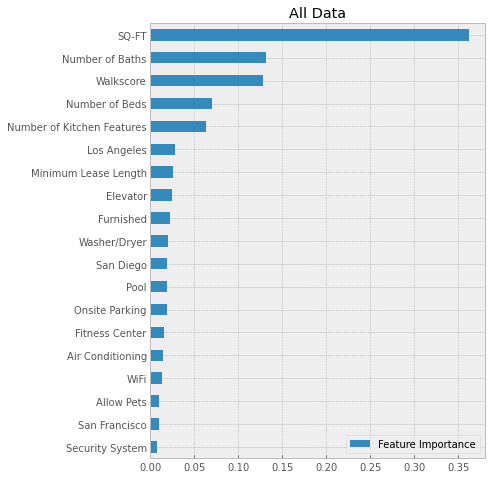

In [188]:
feature_importance_graph(rf_model.feature_importances_, None,'All Data')

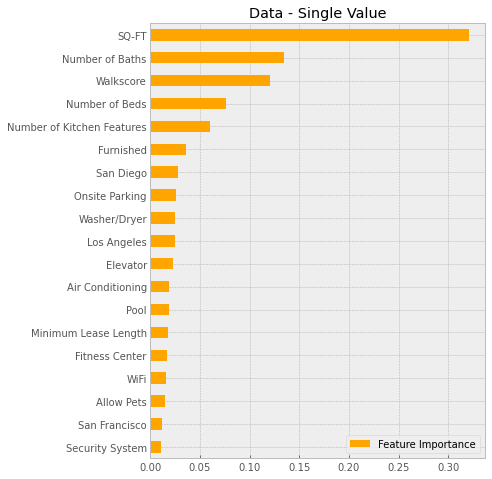

In [197]:
feature_importance_graph(rf_model_nr.feature_importances_, 'orange','Data - Single Value')

#### Linear Regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Rental Price   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              4438.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):                        0.00
Time:                        00:01:32   Log-Likelihood:                     -1.3536e+05
No. Observations:               15588   AIC:                                  2.708e+05
Df Residuals:                   15569   BIC:                                  2.709e+05
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Number of Beds              -212.9345     23.039     -9.242      0.000    -258.094    -167.775
Number of Baths              155.0524     33.591      4.616      0.000      89.211     220.894
SQ-FT                          2.7144      0.048     57.125      0.000       2.621       2.808
Walkscore                     10.1420      0.461     22.015      0.000       9.239      11.045
Allow Pets                   138.3773     35.444      3.904      0.000      68.903     207.851
Minimum Lease Length         -26.3037      2.703     -9.732      0.000     -31.602     -21.006
Onsite Parking              -393.7892     28.371    -13.880      0.000    -449.399    -338.179
Pool                         -79.2072     29.982     -2.642      0.008    -137.976     -20.439
Fitness Center               171.7639     31.909      5.383      0.000     109.218     234.310
Elevator                     256.7965     27.218      9.435      0.000     203.446     310.147
Number of Kitchen Features    -4.2163      3.533     -1.193      0.233     -11.142       2.710
Security System               14.1418     33.182      0.426      0.670     -50.898      79.182
Washer/Dryer                 214.5880     29.310      7.321      0.000     157.136     272.040
WiFi                          69.0132     29.797      2.316      0.021      10.608     127.419
Air Conditioning            -179.2496     28.151     -6.367      0.000    -234.429    -124.070
Furnished                    494.0232     48.589     10.167      0.000     398.783     589.263
Los Angeles                  384.0638     34.806     11.034      0.000     315.840     452.287
San Diego                     64.3728     40.032      1.608      0.108     -14.095     142.841
San Francisco                337.9213     48.506      6.967      0.000     242.845     432.998
==============================================================================
Omnibus:                    23715.118   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         30652454.819
Skew:                           9.099   Prob(JB):                         0.00
Kurtosis:                     219.478   Cond. No.                     4.66e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

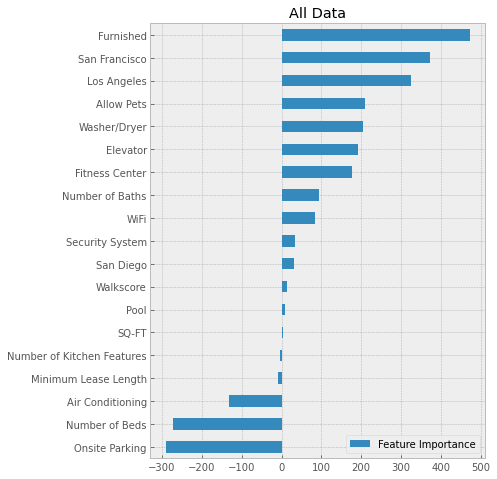

In [193]:
feature_importance_graph(lin_reg.coef_, None,'All Data')
sm.OLS(y_all, X_all).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Rental Price   R-squared (uncentered):                   0.806
Model:                            OLS   Adj. R-squared (uncentered):              0.806
Method:                 Least Squares   F-statistic:                              1558.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):                        0.00
Time:                        12:33:29   Log-Likelihood:                         -62852.
No. Observations:                7122   AIC:                                  1.257e+05
Df Residuals:                    7103   BIC:                                  1.259e+05
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Number of Beds              -174.6073     35.179     -4.963      0.000    -243.569    -105.646
Number of Baths              351.7389     52.642      6.682      0.000     248.545     454.933
SQ-FT                          2.2198      0.067     33.211      0.000       2.089       2.351
Walkscore                     12.5011      0.753     16.603      0.000      11.025      13.977
Allow Pets                     2.6758     53.824      0.050      0.960    -102.835     108.187
Minimum Lease Length         -25.9241      4.749     -5.458      0.000     -35.234     -16.614
Onsite Parking              -475.1954     47.593     -9.985      0.000    -568.492    -381.899
Pool                         -33.0185     49.857     -0.662      0.508    -130.752      64.716
Fitness Center               191.1113     54.584      3.501      0.000      84.111     298.111
Elevator                     169.1172     49.956      3.385      0.001      71.189     267.045
Number of Kitchen Features     0.2746      6.334      0.043      0.965     -12.142      12.691
Security System               67.7692     58.224      1.164      0.244     -46.367     181.905
Washer/Dryer                 155.4473     49.465      3.143      0.002      58.481     252.413
WiFi                         -63.0927     51.243     -1.231      0.218    -163.545      37.360
Air Conditioning            -170.1395     46.690     -3.644      0.000    -261.666     -78.613
Furnished                    861.0923     79.999     10.764      0.000     704.271    1017.913
Los Angeles                  477.5508     61.681      7.742      0.000     356.639     598.463
San Diego                    337.3379     70.441      4.789      0.000     199.252     475.424
San Francisco                354.9002     80.876      4.388      0.000     196.359     513.441
==============================================================================
Omnibus:                    11440.209   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16066957.222
Skew:                          10.128   Prob(JB):                         0.00
Kurtosis:                     234.803   Cond. No.                     5.01e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

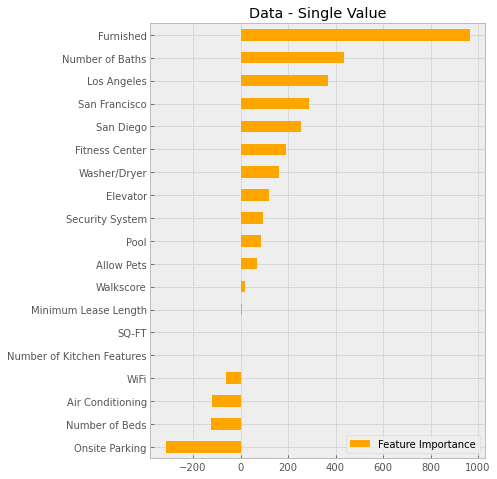

In [198]:
feature_importance_graph(lin_reg_nr.coef_, 'orange','Data - Single Value')
sm.OLS(y_nr, X_nr).fit().summary()